# MSA 2024 Phase 2 - Part 3

Welcome to the competition - in Part 3, you are encouraged to utilize neural network based models for classification.

This notebook builds a simple Multi-Layer Perceptron (MLP) model for the CIFAR-10 dataset, with the use of `keras` to define the model structure.

**Before start working on the competition, please ensure all required libraries are installed and properly set up on your system**:

- `python >= 3.6`,
- `tensorFlow >= 2.0`,
- `keras >= 2.3`,

and any neccassary liburaries for data manipulation and processing, e.g., `numpy`, `pandas`, etc.

In [2]:

!pip install tensorflow


In [3]:
import tensorflow as tf
import numpy as np

# 1. Data loading & preprocessing

The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class. You can download the dataset directly from the competition webpage.

**To train the model, you are expected to use the training label provided in train.csv**.

In [4]:
!pip install --upgrade tensorflow

In [5]:
from tensorflow.keras.datasets import cifar10 # Import the cifar-10 picture dataset into our notebook

In [9]:


from sklearn.model_selection import train_test_split

tf.random.set_seed(101) # set the random seed that is set out by MSA, so all randomness between other workbooks are the same
(x_data, y_data), (x_test, y_test) = cifar10.load_data() # load the data into their respective train and test sets

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.15) # further splits train data into a train, and validation set
x_valid

array([[[[  2,  11,  11],
         [ 10,  14,  16],
         [ 32,  35,  39],
         ...,
         [ 29,  34,  41],
         [ 32,  34,  41],
         [ 26,  34,  39]],

        [[ 20,  41,  47],
         [ 17,  33,  40],
         [ 20,  30,  33],
         ...,
         [ 21,  24,  29],
         [ 25,  27,  31],
         [ 22,  26,  30]],

        [[ 45,  79, 100],
         [ 40,  68,  91],
         [ 19,  42,  53],
         ...,
         [ 14,  26,  36],
         [ 17,  28,  34],
         [ 18,  26,  34]],

        ...,

        [[ 43,  52,  60],
         [ 20,  30,  37],
         [  2,   9,  16],
         ...,
         [ 31,  38,  40],
         [ 15,  28,  30],
         [ 17,  44,  56]],

        [[ 36,  47,  56],
         [ 17,  28,  37],
         [  2,  10,  19],
         ...,
         [ 21,  27,  33],
         [  7,  15,  21],
         [ 12,  22,  34]],

        [[ 65,  77,  88],
         [ 48,  61,  71],
         [ 44,  54,  63],
         ...,
         [  8,  10,  17],
        

In [10]:
# Lets do a bit of preprocessing with the data. There are lists of 3, representing RGB brightness from 0 darkest, to 255 brightest
# Divide them by 255, so the data operates on a scale from 0 to 1, simplifying things for the model
x_train, x_valid, x_test = x_train / 255, x_valid / 255, x_test / 255

In [11]:
# Now we have the y data, showing use the target values. It displays numbers from 1 to 10, categorizing the pictures into 10 categories
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [12]:
# Let's preprocess this data as well by one-hot encoding the data, so we can further evaluate our model's results with confusion matrix and such
y_train = tf.keras.utils.to_categorical(y_train, 10) # turns 1-d array into a 2-d array, where each list has 10 values, encoding all categories
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

## Model selection
`CNNs:` I would be looking at using deep learning models that use CNNs (Convolutional Neural Networks). 
1. They use filters to focus on small localized areas of an image, which helps with spotting pattern in shape, texture, edges etc.
2. The entire image has the same filter across the whole image, helping with pattern recognition despite its orientation in the image.
3. They can build hierarchical features, from most important to least important.
4. They pool layers through reducing image dimensions, but preserving the most important information.

`Resnet-50:` This would be the specific model I'll be using to train and test.
1. It has 50 layers, more complex than Resnet-18, and more shallow than Resnet-152, it strikes a balance between performance and complexity
2. It is more manageable and less demanding on our computational resources
3. It is well-tested and very often used, making research on this model less of a chore, in addition to resources and possible optimization


# 2. Build & train the model

This code demostrates a simple Multi-Layer Perceptron (MLP) model. However, you are encouraged to experiment with more complex deep learning models and techniques to boost your performance.

### a. Import Nessecary Libararies

In [16]:
# With building the model, we will have to import a lot of different things that go into building, training, and evaluating the model

from tensorflow.keras import layers, models
# layers = access to different types of layers to build neural networks
# models = contains functions for creating models, allows building and training models
from tensorflow.keras.applications import ResNet50 # our model architecture, along with loading pre-trained weights/tuning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# allows for random image augmentation during training, to help with model generalization
from tensorflow.keras.optimizers import Adam
# allows adjustments of the learning rate adaptively, or use stochastic gradient descent (minimizing loss function)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# ModelCheckpoint = saves model at every epoch (complete training cycle), therefore allowing you to pick the best model version
# EarlyStopping = allows training stop, when imporvements are minimal, or prevent overfitting
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
# 

### b. Data Augmentation

In [37]:
# Let's create a bit of data augmentation on the images (by applying changes to images) for the model when its training
# This is to not only increase the size of dataset, but also the diversity. It helps the model to generalize and better and prevent overfitting
augment = ImageDataGenerator(
    width_shift_range=0.1, # shifts image horizontally by 10%
    height_shift_range=0.1, # shifts image vertically by 10%
    horizontal_flip=True, # flips image horizontally, 50% of the time
    rotation_range=15 # rotate image by 15 degrees clockwise, or anticlockwise
)

### c. Modify ResNet-50 for Cifar-10, and Model Layering

In [38]:
# For model training, we create a base_model, which refers to pre-trained models with set weights. Where we can build and adapt upon it
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude the fully-connected layers at the top
    input_shape=(32, 32, 3)  # Adjust input shape if necessary
)

In [39]:
# Resenet-50 is designed to train on 224 by 224 images, rather than 32 by 32 of our dataset
# We will need to make some modification so it works with our dataset

input = (32, 32, 3) # the dimension of our image dataset, 32 by 32 with 3 colours of RGB
kernel = (3, 3) # dimensions of the filter used in convolutional layers, aka capturing surrounding details of a particular pixel

model = models.Sequential() # creates sequential models, where you can stack layers upon layers of the new model
# each layer represents the parameter tweaks you make for the base model, and continually layer the other changes and tweaks

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu', padding='same'))
# Conv2D = directly processes image data
# input_size = dpecifies shape of the input data
# ReLU = activation function for neural networks. Produces non-linearity into the model to allow model complexity
# padding = keeps output size same as input size, maintaining spatial dimensions
model.add(BatchNormalization()) # Normalizes activations of the previous layer, 
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu', padding='same'))
# we add another Conv2D layer, where it adds more complex and abstract features
# 1st layer can find basic edges, and 2nd layer can combine these features to detect more complex patterns
model.add(MaxPool2D(pool_size=(2, 2)))
# reducing spatial dimensions of the feature maps. Decreases computational load
model.add(Dropout(0.25))
# randomly sets 25% of the neurons to 0 (off). Prevents overfitting as neurons may become dependant on other neurons

model.add(Flatten())
# transforms 3d output of convolutional layers into a 1D layer
model.add(layers.Dense(512, activation='relu'))
# adds a dense neuron layer with 512 units, and ReLU activation. Helps learn complex features from the output of global average pooling layer
# 512 = the number of neurons in the layer, where these are points that learn different features from the input it recieves
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
# one other dense layer with 10 units (one for each image category), and a softmax. Which ouputs probabilities for each class

for layer in base_model.layers:
    layer.trainable = False
# prevent training on the ResNet-50 model itself, preserving its useful features. We want to focue on training the new added layers instead

X:\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### d. Compile Model

In [40]:
# Next we need to configure the model for training by specifying its optimizers, loss function, and metrics to monitor

model.compile(optimizer='adam', # model optimizer is 'adam'
              # learning_rate = adjustments made per every optimization
              loss='categorical_crossentropy', # loss measures how well the predictions are to actual values. Goal is to minimize loss
              # categorical_crossentropy = calculates the cross-entropy loss between true labels, and predicted probabilities
              metrics=['accuracy']) # metrics used to evaluate model performance, provides more information
              # accuracy = measures proportion of correct predictions, from total predictions

### e. Train the Model

In [135]:
checkpoint = ModelCheckpoint('resnet50_cifar10.keras', monitor='val_accuracy', save_best_only=True, mode='max')
# checkpoint saves the model's weights during training, and keeps the best weights in terms of model accuracy
# 'resnet50_cifar10.keras' = filename to save the model's best weights
# 'val_accuracy' = monitors validation accuracy while training
# 'save_best_only' = only saves the model if accuracy improves
# 'max' = higher value of our monitored metric (accuracy) is better

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# early_stopping as states, stops the training early if the model doesnt improve any further
# 'monitor' = monitors 'val_accuracy' to decide when to stop training
# 'patience' = keeps track of how many epochs where improvement is not made, and stop if it reaches threshold
# 'restore_best_weights' = restores the model weights from the epoch with the best accuracy

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    # provides augmented training data for the model, for more training data variety
                    epochs=10,
                    # number of epochs to train the model
                    validation_data=(x_valid, y_valid),
                    # validation data to monitor model's performance with test sets
                    callbacks=[checkpoint, early_stopping])

loss, accuracy = model.evaluate(x_valid, y_valid) # we will make the trained model, work with our validation dataset before the test set
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.3112 - loss: 2.0138 - val_accuracy: 0.5091 - val_loss: 1.3804
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.4743 - loss: 1.4638 - val_accuracy: 0.5459 - val_loss: 1.3037
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.5232 - loss: 1.3276 - val_accuracy: 0.5683 - val_loss: 1.2405
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5448 - loss: 1.2805 - val_accuracy: 0.6036 - val_loss: 1.1297
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.5567 - loss: 1.2479 - val_accuracy: 0.5963 - val_loss: 1.1491
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.5703 - loss: 1.2058 - val_accuracy: 0.5481 - val_loss: 1.3045
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.5732 - loss: 1.2098 - val_accuracy: 0.5937 - val_loss: 1.1978
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5900 - loss: 1.1724 - 

### Model 1:
`Training time/Epoch:` 40 Seconds

`Highest Accuracy %:` 59.59%

`Validation %:` 66.55%

In [137]:
# I realized the training speed per epoch seems slower than what I'd like to be
# So I'll try make a few adjustments to the code to see how I can optimize it

input = (32, 32, 3) 
kernel = (3, 3)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu')) # removed padding
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# removed checkpoint and early_stopping as the epochs we used to test is so little for these functions to ever be used

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid)) # removed checkpoint and early_stopping from model.fit

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.3504 - loss: 1.8416 - val_accuracy: 0.5191 - val_loss: 1.3504
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5086 - loss: 1.3661 - val_accuracy: 0.5904 - val_loss: 1.1565
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5480 - loss: 1.2597 - val_accuracy: 0.6139 - val_loss: 1.1072
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.5661 - loss: 1.2167 - val_accuracy: 0.6300 - val_loss: 1.0505
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.5843 - loss: 1.1660 - val_accuracy: 0.6383 - val_loss: 1.0346
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.5939 - loss: 1.1500 - val_accuracy: 0.6064 - val_loss: 1.1249
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.6045 - loss: 1.1208 - val_accuracy: 0.6637 - val_loss: 0.9515
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - accuracy: 0.6097 - loss: 1.1028 - 

### Model 2:
`Training time/Epoch:` 35 Seconds

`Highest Accuracy %:` 62.27%

`Validation %:` 68.00%

In [139]:
# Making some more adjustments on the model layers
# I see that there are multiple convolutional layers from some examples online, where filters are doubled per layer
# Doubling is to increase the abstraction of features. The deeper into the network, the features become more abstract and complex
# Doubling also increases network capacity to learn data

input = (32, 32, 3) 
kernel = (3, 3)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.2892 - loss: 2.0568 - val_accuracy: 0.4145 - val_loss: 1.5513
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4524 - loss: 1.4944 - val_accuracy: 0.5545 - val_loss: 1.2015
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5184 - loss: 1.3250 - val_accuracy: 0.5667 - val_loss: 1.2469
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5775 - loss: 1.1880 - val_accuracy: 0.6473 - val_loss: 1.0287
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.6093 - loss: 1.1104 - val_accuracy: 0.5953 - val_loss: 1.1888
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.6334 - loss: 1.0544 - val_accuracy: 0.6869 - val_loss: 0.9085
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.6479 - loss: 1.0138 - val_accuracy: 0.6647 - val_loss: 0.9775
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.6607 - loss: 0.9795 - 

### Model 3:
`Training time/Epoch:` 30 Seconds

`Highest Accuracy %:` 67.52%

`Validation %:` 70.21%

In [140]:
# Quite happy with the results, where the time taken to train the model was decreased by roughly 10 seconds
# I decide to remove the second convolutional 2d layer from 32 and 64

input = (32, 32, 3) 
kernel = (3, 3)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.3196 - loss: 2.0928 - val_accuracy: 0.4801 - val_loss: 1.5000
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4563 - loss: 1.5191 - val_accuracy: 0.4764 - val_loss: 1.5001
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4964 - loss: 1.4080 - val_accuracy: 0.5823 - val_loss: 1.2260
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5267 - loss: 1.3290 - val_accuracy: 0.6285 - val_loss: 1.1033
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5500 - loss: 1.2715 - val_accuracy: 0.6353 - val_loss: 1.0445
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5692 - loss: 1.2216 - val_accuracy: 0.6107 - val_loss: 1.1578
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5864 - loss: 1.1741 - val_accuracy: 0.6389 - val_loss: 1.1301
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5963 - loss: 1.1592 - 

### Model 4:
`Training time/Epoch:` 26 Seconds

`Highest Accuracy %:` 61.37%

`Validation %:` 65.75%

In [141]:
# Results were not the best, but it did speed up training speed
# I decide to remove another part of the layer to see what happens, removing the normalizing layers

input = (32, 32, 3) 
kernel = (3, 3)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.2749 - loss: 1.9226 - val_accuracy: 0.4924 - val_loss: 1.3731
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.4806 - loss: 1.4386 - val_accuracy: 0.5695 - val_loss: 1.1879
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5383 - loss: 1.2843 - val_accuracy: 0.6192 - val_loss: 1.0532
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.5739 - loss: 1.1911 - val_accuracy: 0.6489 - val_loss: 0.9748
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6056 - loss: 1.1108 - val_accuracy: 0.6615 - val_loss: 0.9412
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6224 - loss: 1.0656 - val_accuracy: 0.6632 - val_loss: 0.9433
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6390 - loss: 1.0259 - val_accuracy: 0.6959 - val_loss: 0.8558
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6495 - loss: 0.9962 - 

### Model 5:
`Training time/Epoch:` 24 Seconds

`Highest Accuracy %:` 67.43%

`Validation %:` 69.88%

In [142]:
# Slightly better, in addition to better training time
# I decided to remove the Droupout layers and see the results

input = (32, 32, 3) 
kernel = (3, 3)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.2899 - loss: 1.8958 - val_accuracy: 0.5184 - val_loss: 1.3307
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.4999 - loss: 1.3822 - val_accuracy: 0.5680 - val_loss: 1.1938
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5700 - loss: 1.2076 - val_accuracy: 0.6313 - val_loss: 1.0324
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6092 - loss: 1.0995 - val_accuracy: 0.6301 - val_loss: 1.0553
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6329 - loss: 1.0356 - val_accuracy: 0.6896 - val_loss: 0.8880
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6588 - loss: 0.9764 - val_accuracy: 0.6849 - val_loss: 0.8889
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6722 - loss: 0.9305 - val_accuracy: 0.7147 - val_loss: 0.8109
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6854 - loss: 0.8922 - 

### Model 6:
`Training time/Epoch:` 25 Seconds

`Highest Accuracy %:` 70.24%

`Validation %:` 74.64%

In [144]:
# I'm liking the results. Validation set has an accuracy, almost 4% higher than the previous highest, with reduced time
# Now I want to see if more convolutional layers can create that efficiency

input = (32, 32, 3) 
kernel = (3, 3)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
# I cannot create another (MaxPool2D) as I'd shrink the dimension to (1,1) which would be too small for the model to train on

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.2361 - loss: 1.9803 - val_accuracy: 0.4788 - val_loss: 1.4423
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.4751 - loss: 1.4342 - val_accuracy: 0.5465 - val_loss: 1.2557
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5453 - loss: 1.2585 - val_accuracy: 0.6308 - val_loss: 1.0289
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5955 - loss: 1.1403 - val_accuracy: 0.6069 - val_loss: 1.1127
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6280 - loss: 1.0407 - val_accuracy: 0.6141 - val_loss: 1.1385
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6457 - loss: 1.0056 - val_accuracy: 0.6536 - val_loss: 1.0158
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6689 - loss: 0.9356 - val_accuracy: 0.6816 - val_loss: 0.9362
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6831 - loss: 0.8997 - 

### Model 7:
`Training time/Epoch:` 25 Seconds

`Highest Accuracy %:` 70.89%

`Validation %:` 70.47%

In [146]:
# It's slightly better with the epoch accuracy. However the validation result was a little unlucky
# Since the droupout layers didn't really improve the convolutional layers, I thought I might remove that 0.5 from the last layer

input = (32, 32, 3) 
kernel = (3, 3)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.2674 - loss: 1.9299 - val_accuracy: 0.4613 - val_loss: 1.4711
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.4749 - loss: 1.4371 - val_accuracy: 0.5459 - val_loss: 1.2640
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5506 - loss: 1.2446 - val_accuracy: 0.6185 - val_loss: 1.0562
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.5987 - loss: 1.1186 - val_accuracy: 0.6535 - val_loss: 0.9869
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6344 - loss: 1.0304 - val_accuracy: 0.6553 - val_loss: 1.0282
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6572 - loss: 0.9669 - val_accuracy: 0.7024 - val_loss: 0.8514
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6811 - loss: 0.9096 - val_accuracy: 0.7044 - val_loss: 0.8743
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.6877 - loss: 0.8803 - 

### Model 8:
`Training time/Epoch:` 24 Seconds

`Highest Accuracy %:` 71.88%

`Validation %:` 74.15%

In [147]:
# Slightly better from the previous model
# I wonder whether decreasing the kernel dimensions would further make the model more accurate like last time (from 4 to 3)

input = (32, 32, 3) 
kernel = (2, 2)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.2784 - loss: 1.9114 - val_accuracy: 0.4716 - val_loss: 1.4650
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.4910 - loss: 1.4022 - val_accuracy: 0.5957 - val_loss: 1.1545
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.5659 - loss: 1.2202 - val_accuracy: 0.6141 - val_loss: 1.0883
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6106 - loss: 1.0900 - val_accuracy: 0.5952 - val_loss: 1.1588
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6387 - loss: 1.0141 - val_accuracy: 0.6984 - val_loss: 0.8487
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6668 - loss: 0.9396 - val_accuracy: 0.6480 - val_loss: 1.0511
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6897 - loss: 0.8769 - val_accuracy: 0.7131 - val_loss: 0.8311
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.7046 - loss: 0.8386 - 

### Model 9:
`Training time/Epoch:` 24 Seconds

`Highest Accuracy %:` 72.44%

`Validation %:` 74.32%

In [157]:
# Very marginal improvements with zero extra costs
# What if kernel is (1, 1)?

input = (32, 32, 3) 
kernel = (1, 1)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.3300 - loss: 1.8373 - val_accuracy: 0.5056 - val_loss: 1.3632
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.4993 - loss: 1.3995 - val_accuracy: 0.5673 - val_loss: 1.2048
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.5393 - loss: 1.2978 - val_accuracy: 0.5860 - val_loss: 1.1650
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5712 - loss: 1.2001 - val_accuracy: 0.5875 - val_loss: 1.1599
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.5888 - loss: 1.1642 - val_accuracy: 0.6080 - val_loss: 1.1073
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.5988 - loss: 1.1255 - val_accuracy: 0.6089 - val_loss: 1.0918
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.6206 - loss: 1.0638 - val_accuracy: 0.6104 - val_loss: 1.0885
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.6332 - loss: 1.0324 - 

### Model 10:
`Training time/Epoch:` 32 Seconds

`Highest Accuracy %:` 64.85%

`Validation %:` 64.12%

In [158]:
# Results weren't good, accuracy went down and processing time increased
# I'll do one more test, where I form another convolutional layer

input = (32, 32, 3) 
kernel = (2, 2)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))

model.add(Conv2D(filters=256, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=256, kernel_size=kernel, activation='relu'))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_valid, y_valid))

loss, accuracy = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.2446 - loss: 1.9818 - val_accuracy: 0.4041 - val_loss: 1.6326
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4417 - loss: 1.5041 - val_accuracy: 0.5360 - val_loss: 1.2825
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.5228 - loss: 1.3156 - val_accuracy: 0.5188 - val_loss: 1.3389
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.5670 - loss: 1.2131 - val_accuracy: 0.6056 - val_loss: 1.1177
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6048 - loss: 1.1096 - val_accuracy: 0.6493 - val_loss: 0.9902
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6319 - loss: 1.0318 - val_accuracy: 0.6571 - val_loss: 0.9711
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.6520 - loss: 0.9752 - val_accuracy: 0.6711 - val_loss: 0.9370
Epoch 8/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6747 - loss: 0.9205 - 

### Model 11:
`Training time/Epoch:` 25 Seconds

`Highest Accuracy %:` 70.38%

`Validation %:` 70.75%

## Final Model: Number 9

In [41]:
# Model number 9 will be the chosen model to run on our test dataset
# Before then, we'll train the model with more number of epochs
# We'll also bring back the checkpoints and early_stopping, due to the increase in epochs

input = (32, 32, 3) 
kernel = (2, 2)

model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=kernel, input_shape=input, activation='relu'))
model.add(Conv2D(filters=32, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# The extra double convolutional layer
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=kernel, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=kernel, activation='relu'))

model.add(Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

# I also want to find more details on how the model do other things like precision and recall apart from accuracy
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

checkpoint = ModelCheckpoint('resnet50_cifar10.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(augment.flow(x_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpoint, early_stopping])

loss, accuracy, precision, recall, auc = model.evaluate(x_valid, y_valid)
print(f'Test Accuracy:{accuracy * 100:.2f}%')

Epoch 1/50


X:\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


665/665 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.2966 - auc: 0.7626 - loss: 1.8866 - precision: 0.5448 - recall: 0.0606 - val_accuracy: 0.4721 - val_auc: 0.8775 - val_loss: 1.4563 - val_precision: 0.6518 - val_recall: 0.2803
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.4741 - auc: 0.8809 - loss: 1.4363 - precision: 0.6748 - recall: 0.2595 - val_accuracy: 0.5772 - val_auc: 0.9213 - val_loss: 1.1750 - val_precision: 0.7257 - val_recall: 0.4401
Epoch 3/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.5537 - auc: 0.9133 - loss: 1.2343 - precision: 0.7165 - recall: 0.3789 - val_accuracy: 0.6224 - val_auc: 0.9366 - val_loss: 1.0591 - val_precision: 0.7535 - val_recall: 0.4777
Epoch 4/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6015 - auc: 0.9294 - loss: 1.1152 - precision: 0.7460 - recall: 0.4511 - val_accuracy: 0.6327 - val_auc: 0.9382 - val_loss: 1.0437 - val_precision: 0.7534 - val_recall: 0.5137
Epoch 5/50
665/665 ━━━━━━━━━━━━━━━━

In [22]:
# Let's have a look at the model in more detail
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 31, 31, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 30, 30, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 13, 13, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 5, 5, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 128)           │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,546,080 (13.53 MB)

 Trainable params: 1,182,026 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,364,054 (9.02 MB)

### conv2d:
+ The first layer's output shape is (31, 31, 32). What this meant is (x, y, filter). The x and y represents the length and height of our individual images. From index 0, to index 31, representing the 32 by 32 pixels of image.

+ This is also why the output shape for the first two number decrease by around half. This is done by the max_pooling2d's (2, 2)

+ Total parameters are counted by multiplying kernel size, channels in conv2d layer (RGB) + 1, then number of filters

+ +1 = Accounts for the bias term. The layer produces a single output channel, where it has its associated bias term. Its something the model has to consider the weights of not only the kernel, but also the bias

+ ((kernel_x * kernel_y * channels)+1)*filters   >   ((2 * 2 * 3) + 1) * 32 = 416

### max_pooling2d:
+ It copies the output shape from our convolutional layers, and halving the (x, y) part, as we dictated by the bracket (2, 2). Halving the results

+ They return no parameters, as their job was to only affect the spatial dimension of the output shape

### flatten:
+ They flatten our 3d output shape into a 1D vector, to prepare it for the fully connecting (dense) layers

+ Its output shapre are calculated by multiplying all the output values. 4 * 4 * 128 = 2048

### dense:
+ The fully connected (dense) layer of neurons, specified with (512) neurons by us

+ Parameters are calculated by 512 * 2048 = 1049088 as all the neurons have to connect to all the parameters given to it

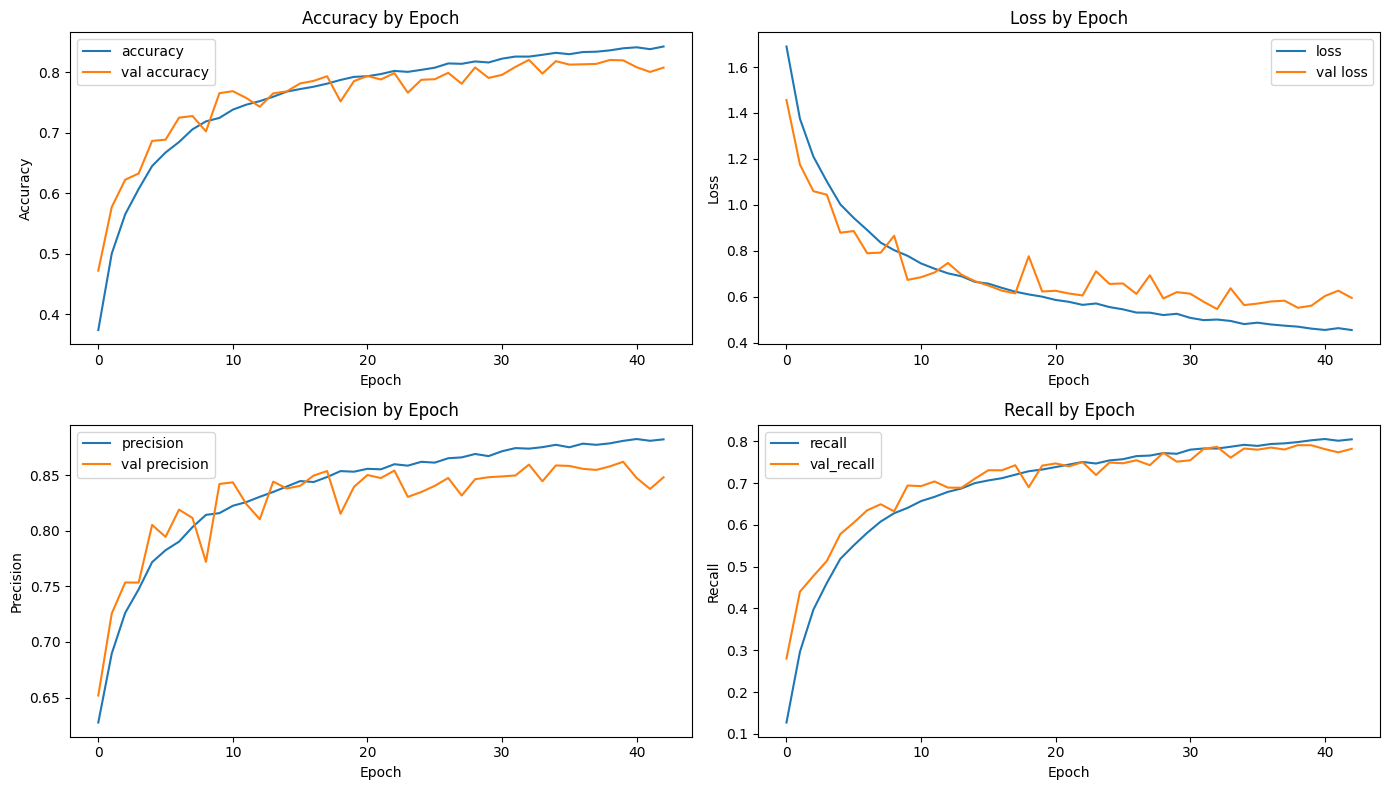

In [42]:
# Next, we'll plot out the model's accuracy, loss, recall, and precision to see if something interesting appears in the data
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

ax1.set(title='Accuracy by Epoch',
       xlabel='Epoch',
       ylabel='Accuracy')
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val accuracy')
ax1.legend()

ax2.set(title='Loss by Epoch',
        xlabel='Epoch',
        ylabel='Loss')
ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val loss')
ax2.legend()

ax3.set(title='Precision by Epoch',
        xlabel='Epoch',
        ylabel='Precision')
ax3.plot(history.history['precision'], label='precision')
ax3.plot(history.history['val_precision'], label='val precision')
ax3.legend()

ax4.set(title='Recall by Epoch',
        xlabel='Epoch',
        ylabel='Recall')
ax4.plot(history.history['recall'], label='recall')
ax4.plot(history.history['val_recall'], label='val_recall')
ax4.legend()

plt.tight_layout();

## Graph Evaluation:

`Accuracy:` Proportion of true positives and true negative, out of the total number of data instances its given (T pos + T neg / No. of Data)

`Loss:` Measure of how well the model's predictions match the true labels. It quantifies the difference between predicted, and actual values

`Precision:` Proportion of true positives, out of all the total positive predictions (true and negative) (T pos / T pos + F pos)

`Recall:` Proportion of true positives, out of all actual positives (T pos / T pos + F neg)

`Val_:` Short for validation, what the model does is they create a validation set, to tune hyperparameters and evaluate the model. Helps prevent overfitting

`Comments:` The graph peaks near the start, where the model has a lot to learn and train from. Then it starts to flatten out, the more epochs the model is trained on, as the model starts to learn all aspects of the training data. Training improvements are consistent, with little variability. 

The 'val' scores are higher than the scores from training during the beginning, but the training scores catches up and surpasses val scores. My hypothesis is, in the beginning, the model still had a lot to learn. And the 'val' data offered an opportunity to continue testing on data.

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


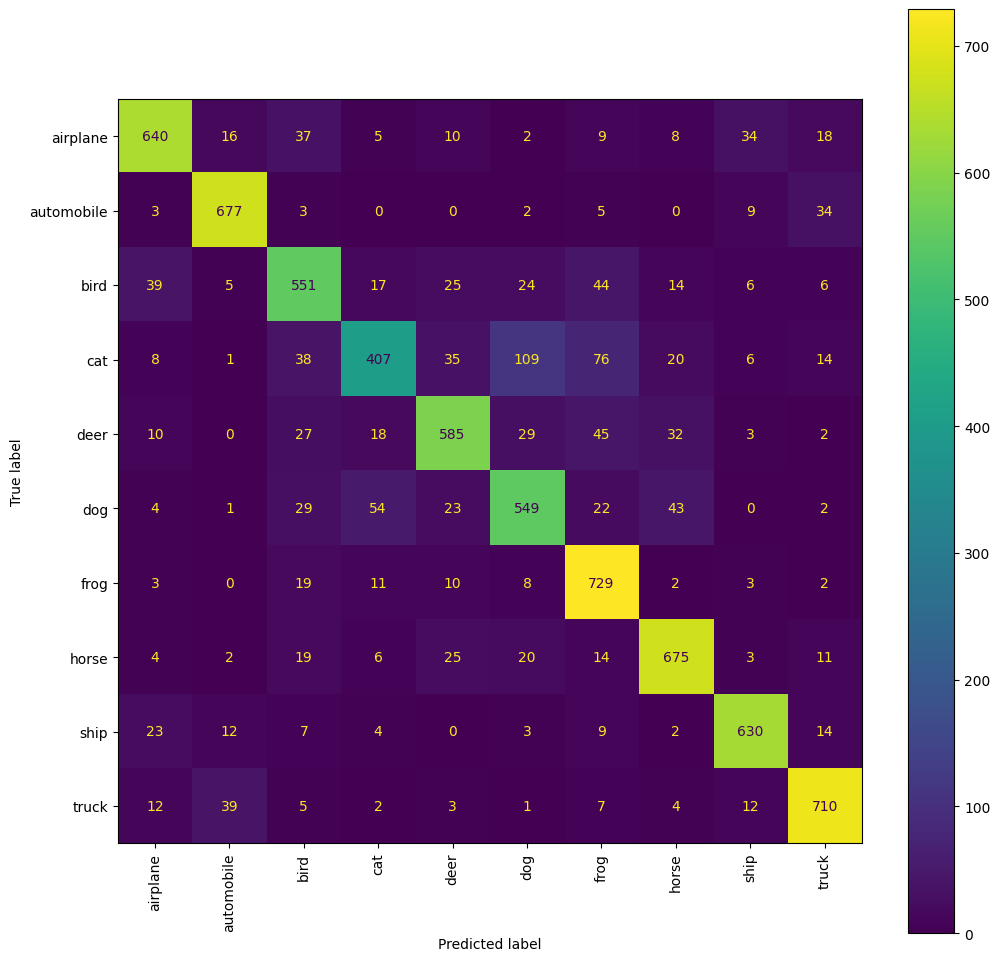

In [54]:
# Next, let's look at the confusion matrix of all 10 categories

# We will need to import some matrix libaries to plot the graphs
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# create a label list for the use within the graph
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

y_pred = model.predict(x_valid) # predict categories from validation dataset
y_pred = np.argmax(y_pred, axis=1) # convert from one-hot encoded data, into categorical labels, to match the 10 labels given
y_valid_label = np.argmax(y_valid, axis=1) # do the same to the y validation set
matrix = confusion_matrix(y_valid_label, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=matrix, # display confusion matrix, inputting our matrix
                                 display_labels=labels) # and our labels

fig, ax = plt.subplots(figsize=(12,12))
display = display.plot(xticks_rotation = 90, ax=ax) # rotate x label 90 degrees so it won't overlap preceeding labels

## Graph Evaluation:

`Diagonal Element:` The diagonal element represents the correct predictions. The higher the numbers indicate more accuracy in predicting a category

`Off-Diagonal Element:` Representing misclassifications of categories. It helps identify with what categories the model gets confused with

`Cat/Dog Confusion:` Model generally does a good job with predicting categories, but we can see it struggles a little with differentiating cats from dogs, which makes sense as appearance between cats and dogs are quite similar.

`General Animal Confusion:` Model does a better job predicting inanimate objects than it does with animate. It could help to train the model separately from animals, and objects, so it can focuses on the details specific to these two groups.

In [55]:
# We can also look at the classification report, to see how well the model predicts each category. Kind of like the confusion matrix.

y_valid_label = np.argmax(y_valid, axis=1)

report = classification_report(y_valid_label, y_pred, target_names=labels)
# target_names = label names for the category in the report
print(report)

              precision    recall  f1-score   support

    airplane       0.86      0.82      0.84       779
  automobile       0.90      0.92      0.91       733
        bird       0.75      0.75      0.75       731
         cat       0.78      0.57      0.66       714
        deer       0.82      0.78      0.80       751
         dog       0.73      0.76      0.74       727
        frog       0.76      0.93      0.83       787
       horse       0.84      0.87      0.85       779
        ship       0.89      0.89      0.89       704
       truck       0.87      0.89      0.88       795

    accuracy                           0.82      7500
   macro avg       0.82      0.82      0.82      7500
weighted avg       0.82      0.82      0.82      7500



## Report Evaluation:

`F1-Score:` Combines precision and recall score as a single metric. Has the ability to control the weight between precision or recall. (e.g. You want Precision 70% of the strength in F1-score, and Recall at 30%)

`Support:` The number of data points for each category

`General Animal Confusion:` Like the confusion matrix from before, we can see there's a slight decrease in accuracy for animals, over inanimate objects.

`Lower support count:` There is a likely reason why the category 'cat' fell low in confusion matrix compared to the other categories. The same can be said for 'ship'. The support number is lowest among the others within the validation set, making the errors in the category weigh more. Makes sense when I split a portion of the data from the original test dataset, and there was some randomness made to select the data for the validation set.

# For some reason, the categorical label numbers from the test dataset they want me to use is all different than the one my model trained on
TEST: 0 = cat
1 = horse
2 = deer
3 = ship
4 = bird
5 = dog
6 = airplane
7 = frog
8 = truck
9 = automobile

TRAIN: 0 = airplane
1 = automobile
2 = bird
3 = cat
4 = deer
5 = dog
6 = frog
7 = horse
8 = ship
9 = truck

In [63]:
# This dictionary should map the original label indices to the indices of the test data
label_mapping = {
    0: 6,
    1: 9,
    2: 4,
    3: 0,
    4: 2,
    5: 5,
    6: 7,
    7: 1,
    8: 3,
    9: 8
}

In [64]:
# Path to the folder containing the images
folder_path = 'test'

# Load images from the directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    image_size=(32, 32),  # Resize images to 32x32 (or the desired size)
    labels=None,  # No labels since it's a test set
    shuffle=False  # Do not shuffle the data
)

# Preprocess the images
test_dataset = test_dataset.map(lambda x: x / 255.0)  # Normalize the images

# Convert the dataset to a numpy array
x_test = np.concatenate([x for x in test_dataset], axis=0) # axis=0, as we're making changes by row, rather than column

# Check the shape of x_test
print(x_test.shape)

Found 5000 files.
(5000, 32, 32, 3)


In [65]:
# This dictionary should map the original label indices to the indices of the test data
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Function to map the labels, so the model's categorical numbers, matches with the way the test categorical numbers are set up
def map_labels(array, mapping):
    return np.vectorize(mapping.get)(array)

# Apply the mapping
y_pred_mapped = map_labels(predicted_labels, label_mapping)
print(y_pred_mapped)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[5 4 8 ... 0 1 4]


In [66]:
id_test = np.arange(len(x_test))

submission = np.column_stack((id_test, y_pred_mapped)) # add to arrays together 
np.savetxt('submission.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

## Summary

## Findings:
I realized how the time it takes to train a model can really add up, especially when you need to tinker and make changes to the layers, and see whether they improve the model or not. So it's really important to consider the speed it trains, compared to its accuracy. From the results the model has outputted, it seems to struggle with animals a bit more, over inanimate objects. This is a little more evident between the confusion of cats and dogs.

## Steps:
`1. Data Preprocessing:` Loaded in Cifar-10 dataset, split the data into train, validation, test sets. Normalized and augmented images, to help with model training

`2. Model Selection:` Researched different models, settled with ResNet50, and looked at ResNet50 model examples, with the different model layers as well

`3. Model Optimizing:` Added 'Adam' optimizer, and also implemented pre-weighted ResNet50 model to speed up training accuracy

`4. Model Tweaking:` Trained several models sequentially, to try and learn what hyperparameters work, and what don't from the previous model

`5. Evaluation:` Best model is evaluated by visualizing it in graphs, to find what interesting patterns and points are when the model is tested on with variable dataset

## Possible next steps:
`Separate Models:` Could try training a separate model that focuses on animals only, and the other on inanimate objects. That way they can focus on the features that discern between these groups.

`More Animal Images:` More images on animals as the model had trouble predicting the categories, over inanimate objects. This is more so for cats and dogs.

`Multiple Models:` Could try combining multiple models together and see if it improves accuracy.

`Regularization Techniques:` These are things like 'Droupout', which through my trials and errors, didn't work as well. But could try experimenting other ones like batch normalization or weight decay. Maybe dropout works better with more convolutional layers, as opposed to one or two.

`Hyperparameter Tuning:` There is definitely more room to play hyperparameters, as there are so many different choices and methods when it comes to layering the model tuning layers.

`More Augmentation:` Could try other augmentation techniques other than shifting and flipping horizontally. Such as adverserial training, making imperceptible changes to the images, whilst being significant enough to confuse the model.